# This code is a more advanced example of Cpx-Liquid melt matching
- It adapts the approach of Scruggs and Putirka, 2018 (https://doi.org/10.2138/am-2018-6058), where you have lots of whole rock compositions for basalts, lots for rhyolites, but nothing in between. 
- It uses a variety of mixing and sampling algorithms to add "synthetic liquids" you can the feed into the melt matching algoorithm
- We suggest you first go through the Cpx_MeltMatch1_Gleeson2020 tutorial for an introduction to the melt matching code

## Load python things

In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append("../../..")
import matplotlib.pyplot as plt
import Thermobar as pt
pd.options.display.max_columns = None

## This sets plotting parameters

In [2]:
# This sets some plotting things
plt.rcParams["font.family"] = 'arial'
plt.rcParams["font.size"] =12
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["mathtext.fontset"] = "dejavusans"
plt.rcParams['patch.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1 
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 6 # Sets length of ticks
plt.rcParams["ytick.major.size"] = 4 # Sets length of ticks
plt.rcParams["ytick.labelsize"] = 12 # Sets size of numbers on tick marks
plt.rcParams["xtick.labelsize"] = 12 # Sets size of numbers on tick marks
plt.rcParams["axes.titlesize"] = 14 # Overall title
plt.rcParams["axes.labelsize"] = 14 # Axes labels
____________________________________________________________________________________________________________________

C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Step 1 - Import all measured Liquids and Cpxs

In [ ]:
out=pt.import_excel('Scruggs_Input.xlsx', sheet_name="Liquids")
my_input=out['my_input']
myLiquids1=out['Liqs']

out2=pt.import_excel('Scruggs_Input.xlsx', sheet_name="Cpxs")
my_input2=out2['my_input']
myCpxs1=out2['Cpxs']

# Step 2 - Generate Silicic and Mafic end-members (adding noise)

In [ ]:

Sil_endmember_noise1=pt.add_noise_sample_1phase(phase_comp=myLiquids1,  duplicates=5, filter_q='SiO2_Liq > 65',
                     phase_err_type="Perc", noise_percent=1, err_dist="normal", append=True)



Maf_endmember_noise1=pt.add_noise_sample_1phase(phase_comp=myLiquids1, duplicates=5, filter_q='SiO2_Liq < 53.8 & MgO_Liq>4', 
                     phase_err_type="Perc", noise_percent=1, err_dist="normal", append=True)

# Step 3 - Generate synthetic liquids by mixing end-members

In [ ]:
Mixed_noise1_selfbig=pt.calculate_bootstrap_mixes(endmember1=Sil_endmember_noise1, 
                     endmember2=Maf_endmember_noise1, num_samples = 500, self_mixing = "Partial")

# Step 4 - Combine synthetic liquids and measured liquids

In [ ]:
Liq_Comp=pd.concat([Mixed_noise1_selfbig.reset_index(drop=True), 
         myLiquids1.reset_index(drop=True)], axis=0).reset_index(drop=True).fillna(0)

# Step 5 - Set water content (following Scruggs and Putirka, 2018)

In [ ]:
Liq_Comp['H2O_Liq']=Liq_Comp['SiO2_Liq']*0.06995+0.383

# Step 6 - Perform melt matching to calculate pressures and temperatures

In [ ]:
melt_match_out_syn=pt.calculate_cpx_liq_press_temp_matching(liq_comps=Liq_Comp, cpx_comps=myCpxs1, 
                      equationP="P_Neave2017", equationT="T_Put2008_eq33", KdMatch=0.27, KdErr=0.03)
Syn_Avs=melt_match_out_syn['Av_PTs']
Syn_All=melt_match_out_syn['All_PTs']

## Inspect data to check it has read in correctly.
- .head() displays the first N columns. Check for any columns which are all zero's which you think you entered data for. Check column headings in excel

In [4]:
display(myLiquids1.head())
display(myCpxs1.head())

C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeOt_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,Cr2O3_Liq,P2O5_Liq,H2O_Liq,Fe3FeT_Liq,NiO_Liq,CoO_Liq,CO2_Liq,Sample_ID_Liq
0,69.67,0.360,15.690,2.645412,0.07,1.36,3.270,4.14,2.67,0.0,0.120,0.0,0,0.0,0.0,0.0,0
1,69.34,0.375,15.575,2.627416,0.06,1.39,3.255,4.19,2.69,0.0,0.120,0.0,0,0.0,0.0,0.0,1
2,56.14,0.770,18.680,6.658520,0.12,4.08,8.080,3.23,1.24,0.0,0.240,0.0,0,0.0,0.0,0.0,2
3,56.11,0.770,18.710,6.631526,0.12,4.17,8.000,3.19,1.28,0.0,0.236,0.0,0,0.0,0.0,0.0,3
4,57.94,0.570,18.090,6.073650,0.12,3.97,7.730,3.21,1.44,0.0,0.106,0.0,0,0.0,0.0,0.0,4


,SiO2_Cpx,TiO2_Cpx,Al2O3_Cpx,FeOt_Cpx,MnO_Cpx,MgO_Cpx,CaO_Cpx,Na2O_Cpx,K2O_Cpx,Cr2O3_Cpx,Sample_ID_Cpx
0,47.558,0.880,7.697,8.230,0.183,13.257,21.465,0.244,0,0.034,0
1,50.643,0.548,4.410,7.811,0.190,16.048,19.995,0.182,0,0.031,1
2,47.000,1.280,8.458,7.998,0.176,13.159,21.713,0.240,0,0.041,2
3,51.328,0.391,2.756,12.116,0.651,15.586,16.798,0.195,0,0.000,3
4,50.770,0.416,2.910,11.054,0.593,14.724,19.081,0.218,0,0.010,4


## This section calculates melt matching using just the measured liquids and clinopyroxenes
- here, we have specified to use the barometer of Neave and Putirka, 2017, and the thermometer of Putirka (2008) eq 33
- We are using the default equilibrium filters for DiHd, CaTs and EnFs errors from Neave and Putirka (2017)
- And overwriting the default for Kd to 0.27, KdErr=0.03 following Scruggs and Putirka
- Add water based on SiO2 content

In [5]:
melt_match_out=pt.calculate_cpx_liq_press_temp_matching(liq_comps=myLiquids1, cpx_comps=myCpxs1, equationP="P_Neave2017",
                                                     equationT="T_Put2008_eq33", KdMatch=0.27, KdErr=0.03, H2O_Liq=myLiquids1['SiO2_Liq']*0.06995+0.383)
Meas_Avs=melt_match_out['Av_PTs']
Meas_All=melt_match_out['All_PTs']

C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Considering 27456 Liq-Cpx pairs, be patient if this is >>1 million!
the code is evaluating Kd matches using Kd=0.27
4986 Matches remaining after initial Kd filter. Now moving onto iterative calculations


C:\Users\penny\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Finished calculating Ps and Ts, now just averaging the results. Almost there!
Done!


- The output is a dictionary, with all matches called "All_PTs" and averages for each Cpx shown as Av_PTs

In [6]:
# Retrieving all matches
Av_outputs=melt_match_out['All_PTs']
Av_outputs.head()

C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Sample_ID_Cpx,P_kbar_calc,T_K_calc,Eq Tests Neave2017?,Delta_Kd_Put2008,Delta_Kd_Mas2013,Delta_EnFs,Delta_CaTs,Delta_DiHd,DeltaKd_userselected=0.27,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeOt_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,Cr2O3_Liq,P2O5_Liq,H2O_Liq,Fe3FeT_Liq,NiO_Liq,CoO_Liq,CO2_Liq,SiO2_Liq_mol_frac,MgO_Liq_mol_frac,MnO_Liq_mol_frac,FeOt_Liq_mol_frac,CaO_Liq_mol_frac,Al2O3_Liq_mol_frac,Na2O_Liq_mol_frac,K2O_Liq_mol_frac,TiO2_Liq_mol_frac,P2O5_Liq_mol_frac,Cr2O3_Liq_mol_frac,SiO2_Liq_cat_frac,MgO_Liq_cat_frac,MnO_Liq_cat_frac,FeOt_Liq_cat_frac,CaO_Liq_cat_frac,Al2O3_Liq_cat_frac,Na2O_Liq_cat_frac,K2O_Liq_cat_frac,TiO2_Liq_cat_frac,P2O5_Liq_cat_frac,Cr2O3_Liq_cat_frac,FeO_Liq_cat_frac,Mg_Number_Liq_NoFe3,Mg_Number_Liq_Fe3,ID_Liq,SiO2_Cpx,TiO2_Cpx,Al2O3_Cpx,FeOt_Cpx,MnO_Cpx,MgO_Cpx,CaO_Cpx,Na2O_Cpx,K2O_Cpx,Cr2O3_Cpx,SiO2_Cpx_cat_6ox,MgO_Cpx_cat_6ox,FeOt_Cpx_cat_6ox,CaO_Cpx_cat_6ox,Al2O3_Cpx_cat_6ox,Na2O_Cpx_cat_6ox,K2O_Cpx_cat_6ox,MnO_Cpx_cat_6ox,TiO2_Cpx_cat_6ox,Cr2O3_Cpx_cat_6ox,oxy_renorm_factor,Al_IV_cat_6ox,Al_VI_cat_6ox,Cation_Sum_Cpx,CrCaTs,a_cpx_En,Mgno_CPX,Jd,CaTs,CaTi,DiHd_1996,EnFs,DiHd_2003,Di_Cpx,ID_CPX,Kd_Fe_Mg,Kd_Fe_Mg_NoFe3,lnK_Jd_liq,lnK_Jd_DiHd_liq_1996,lnK_Jd_DiHd_liq_2003,Kd_Fe_Mg_IdealWB,DeltaFeMg_WB,T_Liq_MinP,T_Liq_MaxP,Kd_Ideal_Put,Kd_Ideal_Masotta,DiHd_Pred_Mollo,EnFs_Pred_Mollo,CaTs_Pred_P1999,CrCaTS_Pred_P1999,DeltaKd_KdMatch_userSp
49,12,-0.599612,1295.021032,N,0.035637,0.132536,0.038145,0.017382,0.041664,0.003897,56.14,0.770,18.68,6.658520,0.12,4.08,8.080,3.23,1.240,0.0,0.2400,4.309993,0.0,0.0,0.0,0.0,0.609154,0.065997,0.001103,0.060421,0.093938,0.119442,0.033976,0.008582,0.006285,0.001102,0.0,0.523732,0.056742,0.000948,0.051948,0.080765,0.205386,0.058423,0.014758,0.005403,0.001896,0.0,0.051948,0.522045,0.522045,2.0,52.003,0.396,3.011,7.392,0.212,16.537,20.439,0.157,0.0,0.091,1.913065,0.906915,0.227415,0.805627,0.130548,0.011198,0.0,0.006606,0.010958,0.002647,0.0,0.086935,0.043613,4.014979,0.001323,0.16995,0.799511,0.011198,0.032415,0.02726,0.744629,0.194851,0.744629,0.591896,12.0,0.273897,0.273897,1.224456,-4.509698,-4.509698,0.257709,0.016188,1253.809576,1450.180612,0.238260,0.141361,0.786293,0.156706,0.015033,0.0,0.003897
50,12,-0.524870,1295.564031,N,0.042686,0.137866,0.036441,0.017456,0.040763,0.011079,56.11,0.770,18.71,6.631526,0.12,4.17,8.000,3.19,1.280,0.0,0.2360,4.307894,0.0,0.0,0.0,0.0,0.608838,0.067454,0.001103,0.060177,0.093009,0.119636,0.033556,0.008859,0.006285,0.001084,0.0,0.523445,0.057993,0.000948,0.051737,0.079964,0.205713,0.057699,0.015233,0.005403,0.001864,0.0,0.051737,0.528498,0.528498,3.0,52.003,0.396,3.011,7.392,0.212,16.537,20.439,0.157,0.0,0.091,1.913065,0.906915,0.227415,0.805627,0.130548,0.011198,0.0,0.006606,0.010958,0.002647,0.0,0.086935,0.043613,4.014979,0.001323,0.16995,0.799511,0.011198,0.032415,0.02726,0.744629,0.194851,0.744629,0.591896,12.0,0.281079,0.281079,1.236431,-4.499259,-4.499259,0.257709,0.023370,1254.001140,1450.436888,0.238393,0.143213,0.785392,0.158410,0.014959,0.0,0.011079
53,12,-0.855056,1295.545362,N,0.054859,0.144717,0.032289,0.017783,0.054906,0.023247,57.42,0.625,18.28,6.402077,0.12,4.20,8.085,3.06,1.395,0.0,0.0965,4.399529,0.0,0.0,0.0,0.0,0.617825,0.067369,0.001094,0.057608,0.093208,0.115906,0.031918,0.009574,0.005058,0.000440,0.0,0.533602,0.058185,0.000945,0.049754,0.080502,0.200211,0.055134,0.016538,0.004369,0.000759,0.0,0.049754,0.539045,0.539045,6.0,52.003,0.396,3.011,7.392,0.212,16.537,20.439,0.157,0.0,0.091,1.913065,0.906915,0.227415,0.805627,0.130548,0.011198,0.0,0.006606,0.010958,0.002647,0.0,0.086935,0.043613,4.014979,0.001323,0.16995,0.799511,0.011198,0.032415,0.02726,0.744629,0.194851,0.744629,0.591896,12.0,0.293247,0.293247,1.270572,-4.436424,-4.436424,0.257709,0.035538,1255.387085,1452.291370,0.238388,0.148530,0.799535,0.162562,0.014631,0.0,0.023247
55,12,0.316841,1319.462929,N,0.047304,0.159316,0.049339,0.014507,0.012044,0.021496,53.02,0.670,19.11,7.621306,0.14,4.97,9.590,2.82,0.670,0.0,0.1050,4.091749,0.0,0.0,0.0,0.0,0.575258,0.0

In [7]:
# Retrieving average matches
Av_outputs=melt_match_out['Av_PTs']
Av_outputs.head()

C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,No. of liquids averaged,Sample_ID_Cpx,Mean_T_K_calc,st_dev_T_K_calc,Mean_P_kbar_calc,st_dev_P_kbar_calc,Mean_Delta_Kd_Put2008,Mean_Delta_Kd_Mas2013,Mean_Delta_EnFs,Mean_Delta_CaTs,Mean_Delta_DiHd,Mean_DeltaKd_userselected=0.27,Mean_SiO2_Liq,Mean_TiO2_Liq,Mean_Al2O3_Liq,Mean_FeOt_Liq,Mean_MnO_Liq,Mean_MgO_Liq,Mean_CaO_Liq,Mean_Na2O_Liq,Mean_K2O_Liq,Mean_Cr2O3_Liq,Mean_P2O5_Liq,Mean_H2O_Liq,Mean_Fe3FeT_Liq,Mean_NiO_Liq,Mean_CoO_Liq,Mean_CO2_Liq,Mean_SiO2_Liq_mol_frac,Mean_MgO_Liq_mol_frac,Mean_MnO_Liq_mol_frac,Mean_FeOt_Liq_mol_frac,Mean_CaO_Liq_mol_frac,Mean_Al2O3_Liq_mol_frac,Mean_Na2O_Liq_mol_frac,Mean_K2O_Liq_mol_frac,Mean_TiO2_Liq_mol_frac,Mean_P2O5_Liq_mol_frac,Mean_Cr2O3_Liq_mol_frac,Mean_SiO2_Liq_cat_frac,Mean_MgO_Liq_cat_frac,Mean_MnO_Liq_cat_frac,Mean_FeOt_Liq_cat_frac,Mean_CaO_Liq_cat_frac,Mean_Al2O3_Liq_cat_frac,Mean_Na2O_Liq_cat_frac,Mean_K2O_Liq_cat_frac,Mean_TiO2_Liq_cat_frac,Mean_P2O5_Liq_cat_frac,Mean_Cr2O3_Liq_cat_frac,Mean_FeO_Liq_cat_frac,Mean_Mg_Number_Liq_NoFe3,Mean_Mg_Number_Liq_Fe3,Mean_ID_Liq,Mean_SiO2_Cpx,Mean_TiO2_Cpx,Mean_Al2O3_Cpx,Mean_FeOt_Cpx,Mean_MnO_Cpx,Mean_MgO_Cpx,Mean_CaO_Cpx,Mean_Na2O_Cpx,Mean_K2O_Cpx,Mean_Cr2O3_Cpx,Mean_SiO2_Cpx_cat_6ox,Mean_MgO_Cpx_cat_6ox,Mean_FeOt_Cpx_cat_6ox,Mean_CaO_Cpx_cat_6ox,Mean_Al2O3_Cpx_cat_6ox,Mean_Na2O_Cpx_cat_6ox,Mean_K2O_Cpx_cat_6ox,Mean_MnO_Cpx_cat_6ox,Mean_TiO2_Cpx_cat_6ox,Mean_Cr2O3_Cpx_cat_6ox,Mean_oxy_renorm_factor,Mean_Al_IV_cat_6ox,Mean_Al_VI_cat_6ox,Mean_Cation_Sum_Cpx,Mean_CrCaTs,Mean_a_cpx_En,Mean_Mgno_CPX,Mean_Jd,Mean_CaTs,Mean_CaTi,Mean_DiHd_1996,Mean_EnFs,Mean_DiHd_2003,Mean_Di_Cpx,Mean_ID_CPX,Mean_Kd_Fe_Mg,Mean_Kd_Fe_Mg_NoFe3,Mean_lnK_Jd_liq,Mean_lnK_Jd_DiHd_liq_1996,Mean_lnK_Jd_DiHd_liq_2003,Mean_Kd_Fe_Mg_IdealWB,Mean_DeltaFeMg_WB,Mean_T_Liq_MinP,Mean_T_Liq_MaxP,Mean_Kd_Ideal_Put,Mean_Kd_Ideal_Masotta,Mean_DiHd_Pred_Mollo,Mean_EnFs_Pred_Mollo,Mean_CaTs_Pred_P1999,Mean_CrCaTS_Pred_P1999,Mean_DeltaKd_KdMatch_userSp
0,46,12,1303.295652,8.041482,-0.640971,0.359002,0.040536,0.138651,0.040808,0.016735,0.042241,0.012172,55.973370,0.672935,18.421993,6.810997,0.127355,4.278623,8.673804,3.097138,1.151993,0.0,0.095833,4.298337,0.0,0.0,0.0,0.0,0.604529,0.068891,0.001165,0.061521,0.100376,0.117250,0.032427,0.007936,0.005467,0.000438,0.0,0.522018,0.059491,0.001006,0.053127,0.086684,0.202494,0.055998,0.013705,0.004721,0.000757,0.0,0.053127,0.528079,0.528079,52.673913,52.003,0.396,3.011,7.392,0.212,16.537,20.439,0.157,0.0,0.091,1.913065,0.906915,0.227415,0.805627,0.130548,0.011198,0.0,0.006606,0.010958,0.002647,0.0,0.086935,0.043613,4.014979,0.001323,0.169950,0.799511,0.011198,0.032415,0.027260,0.744629,0.194851,0.744629,0.591896,12.0,0.280809,0.280809,1.289457,-4.348543,-4.348543,0.257709,0.023100,1261.728292,1460.791198,0.240273,0.142158,0.786870,0.154043,0.015680,0.0,0.012172
0,27,16,1294.164288,11.738025,1.945557,0.439403,0.050277,0.148205,0.002702,0.009267,0.028083,0.023192,56.685926,0.682407,18.278704,6.752832,0.127778,3.984630,8.392222,3.245185,1.217778,0.0,0.099574,4.348181,0.0,0.0,0.0,0.0,0.611993,0.064131,0.001168,0.060975,0.097081,0.116299,0.033968,0.008387,0.005543,0.000455,0.0,0.527977,0.055335,0.001008,0.052609,0.083770,0.200668,0.058599,0.014467,0.004781,0.000785,0.0,0.052609,0.512866,0.512866,62.037037,52.702,0.260,2.140,7.146,0.248,14.661,22.858,0.313,0.0,0.047,1.946267,0.807137,0.220696,0.904454,0.093142,0.022411,0.0,0.007757,0.007222,0.001372,0.0,0.053733,0.039409,4.010459,0.000686,0.068859,0.785275,0.022411,0.016998,0.018368,0.868403,0.079715,0.868403,0.676831,16.0,0.288320,0.288320,1.925725,-3.923827,-3.923827,0.255061,0.034958,1242.284013,1434.798562,0.238043,0.140115,0.843400,0.078322,0.007731,0.0,0.023192
0,5,26,1304.251537,4.271816,0.623434,0.441238,0.024975,0.131124,0.040744,0.028638,0.033057,0.016434,54.998000,0.796000,18.850000,7.664496,0.138000,3.948000,8.572000,3.258000,0.952000,0.0,0.110400,4.230110,0.0,0.0,0.0,0.0,0.597052,0.063890,0.001269,0.069589,0.099719,0.120601,0.034283,0.006590,0.006500,0.000507,0.0,0.513827,0.054986,0.00

# Now lets make some more synthetic liquids
- As Scruggs and Putrika (2018) showed, measured liquids have a clear Daly gap, and it is probably some cpxs crystallized from liquids between the analsed mafic and silicic end members
- They use a mixing model to generate liquids lying between these two extremes to then feed into the Cpx-Liq spreadsheet (see https://www.youtube.com/watch?v=CjKvgXrah_k&list=PLnOXMT9X-AL_No_vUkkx8tYrahGQ1X4Kh&index=2&t=13s)
- Here, we say, take liquids with SiO2_Liq>65 wt% (e.g., our evolved end member), add some noise to account for the silicic liquids we did not sample, in this case, 0.5% noise distributed normally, and 8 synthetic samples per measured sample. This will be important if there are relatively large gaps between measured samples

In [9]:
Sil_endmember_somenoise1=pt.add_noise_sample_1phase(phase_comp=myLiquids1, phase_err_type="Perc", noise_percent=0.5,
                           duplicates=8, err_dist="normal", filter_q='SiO2_Liq > 65', append=True)

C:\Users\penny\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Text(0, 0.5, 'MgO Liquid')

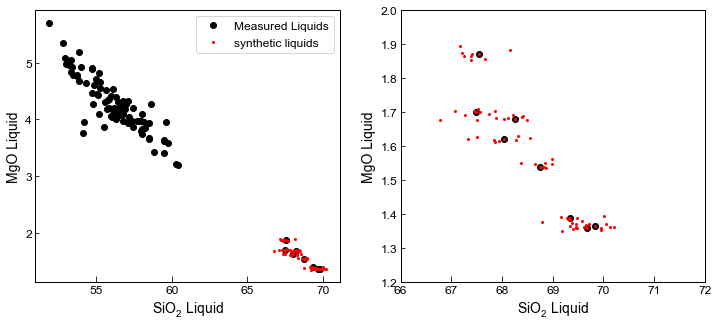

In [10]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(myLiquids1['SiO2_Liq'], myLiquids1['MgO_Liq'], 'ok', label='Measured Liquids')
ax1.plot(Sil_endmember_somenoise1['SiO2_Liq'], Sil_endmember_somenoise1['MgO_Liq'], 'or', markerfacecolor='r', markersize=2,  label='synthetic liquids')
np.shape(Sil_endmember_somenoise1)
ax1.legend()
ax1.set_xlabel('SiO$_2$ Liquid')
ax1.set_ylabel('MgO Liquid')

ax2.plot(myLiquids1['SiO2_Liq'], myLiquids1['MgO_Liq'], 'ok', label='Measured Liquids')
ax2.plot(Sil_endmember_somenoise1['SiO2_Liq'], Sil_endmember_somenoise1['MgO_Liq'], 'or', markerfacecolor='r', markersize=2,  label='synthetic liquids')

ax2.set_xlim([66, 72])
ax2.set_ylim([1.2, 2])
ax2.set_xlabel('SiO$_2$ Liquid')
ax2.set_ylabel('MgO Liquid')


# Lets make both a silicic and mafic end mmber, with 1% normally distributed noise. 
- Silicic end member, SiO2>65, Mafic, SiO2<53.8, and MgO>4

C:\Users\penny\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Text(0, 0.5, 'FeOt Liquid')

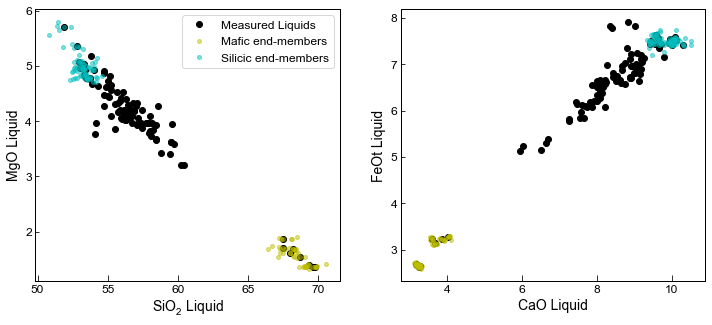

In [12]:
Sil_endmember_noise1=pt.add_noise_sample_1phase(phase_comp=myLiquids1, phase_err_type="Perc", noise_percent=1,
                           duplicates=5, err_dist="normal", filter_q='SiO2_Liq > 65', append=True)
Maf_endmember_noise1=pt.add_noise_sample_1phase(phase_comp=myLiquids1, phase_err_type="Perc", noise_percent=1,
                           duplicates=5, err_dist="normal", filter_q='SiO2_Liq < 53.8 & MgO_Liq>4', append=True)

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(myLiquids1['SiO2_Liq'], myLiquids1['MgO_Liq'], 'ok', markerfacecolor='k', label='Measured Liquids')
ax1.plot(Sil_endmember_noise1['SiO2_Liq'], Sil_endmember_noise1['MgO_Liq'], 'oy', markeredgecolor='y', label='Mafic end-members',  markersize=4, alpha=0.5)
ax1.plot(Maf_endmember_noise1['SiO2_Liq'], Maf_endmember_noise1['MgO_Liq'], 'oc', markeredgecolor='c', label='Silicic end-members',  markersize=4, alpha=0.5)
ax1.set_xlabel('SiO$_2$ Liquid')
ax1.set_ylabel('MgO Liquid')
ax1.legend()
ax2.plot(myLiquids1['CaO_Liq'], myLiquids1['FeOt_Liq'], 'ok', markerfacecolor='k', label='Measured Liquids')
ax2.plot(Sil_endmember_noise1['CaO_Liq'], Sil_endmember_noise1['FeOt_Liq'], 'oy', markeredgecolor='y', label='Mafic end-members',  markersize=4, alpha=0.5)
ax2.plot(Maf_endmember_noise1['CaO_Liq'], Maf_endmember_noise1['FeOt_Liq'], 'oc', markeredgecolor='c', label='Silicic end-members',  markersize=4, alpha=0.5)
ax2.set_xlabel('CaO Liquid')
ax2.set_ylabel('FeOt Liquid')


# There are now a number of ways to mix these end-members to incorperate the liquid line of descent. 

### Option 1 - Mixing by bootstrapping, with no self mixing. 
- Takes end member 1 (Sil_endmember_noise1) and and end member 2 (Maf_endmember_noise1). Makes each input the length of the number of samples you specify with number samples. E.g., say when you generate your end member 1, you end up with 2000 samples. if you enter num_samples=500, it will randomly sample down to 500 samples. Conversely, if your end member only has 80 samples, it will scale it up by randomly resampling until you have 500 inputs. 
- Basically, if you generate more samples at the "end member" stage, they are generated with noise. If you generate more here, they are randomly sampled without adding noise. 
- The code then randomly mixes each element of end member 1 with end member 2 in a proportion determined by a random number generator between 0 and 1.

C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'FeOt Liquid')

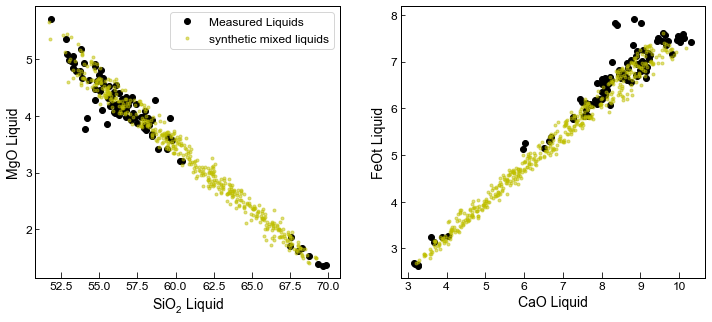

In [13]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 5))
Mixed_noise5=pt.calculate_bootstrap_mixes(Sil_endmember_noise1, Maf_endmember_noise1, num_samples = 500, self_mixing = False)
ax1.plot(myLiquids1['SiO2_Liq'], myLiquids1['MgO_Liq'], 'ok', label='Measured Liquids')
ax1.plot(Mixed_noise5['SiO2_Liq'], Mixed_noise5['MgO_Liq'], 'oy', markerfacecolor='y', markersize=3, label='synthetic mixed liquids',  alpha=0.5)
ax1.set_xlabel('SiO$_2$ Liquid')
ax1.set_ylabel('MgO Liquid')
ax1.legend()
ax2.plot(myLiquids1['CaO_Liq'], myLiquids1['FeOt_Liq'], 'ok', label='Measured Liquids')
ax2.plot(Mixed_noise5['CaO_Liq'], Mixed_noise5['FeOt_Liq'], 'oy', markerfacecolor='y', markersize=3,  alpha=0.5)

ax2.set_xlabel('CaO Liquid')
ax2.set_ylabel('FeOt Liquid')

### Option 2 - Using self mixing
- This will not only mix silicic and mafic end member, it will also mix between mafic end members, and between silic end-members. 
- This will cluster more liquids around where you have defined your end members, with more sparse coverage inbetween. 

C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'MgO Liquid')

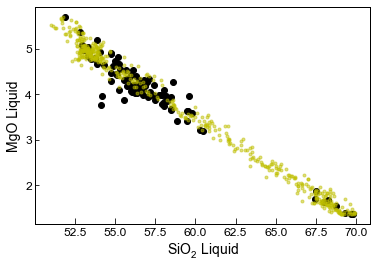

In [14]:
Mixed_noise5_self=pt.calculate_bootstrap_mixes(Sil_endmember_noise1, Maf_endmember_noise1, num_samples = 500, self_mixing = True)
plt.plot(myLiquids1['SiO2_Liq'], myLiquids1['MgO_Liq'], 'ok', label='Measured Liquids')
plt.plot(Mixed_noise5_self['SiO2_Liq'], Mixed_noise5_self['MgO_Liq'], 'oy', markerfacecolor='y', markersize=3,  alpha=0.5)
plt.xlabel('SiO$_2$ Liquid')
plt.ylabel('MgO Liquid')

# If you want more even coverage in the middle, but some mixing at the edges, can use the keyword self_mixing=Partial
- This will give half your liquids from self mixing, half from non-self mixing

C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'MgO Liquid')

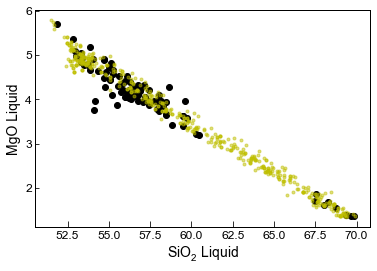

In [16]:
Mixed_noise1_selfbig=pt.calculate_bootstrap_mixes(endmember1=Sil_endmember_noise1, endmember2=Maf_endmember_noise1, 
                                                  num_samples = 500, self_mixing = "Partial")
plt.plot(myLiquids1['SiO2_Liq'], myLiquids1['MgO_Liq'], 'ok', label='Measured Liquids')

#Mixed_noise5_selfbig.sample(n=500, replace = True).to_numpy()
plt.plot(Mixed_noise1_selfbig['SiO2_Liq'], Mixed_noise1_selfbig['MgO_Liq'], 'oy', markerfacecolor='y', markersize=3,  alpha=0.5)
plt.xlabel('SiO$_2$ Liquid')
plt.ylabel('MgO Liquid')

# Now want to use these synthetic liquids for melt matching

## First, lets combine these synthetic liquids with all measured liquids to get an even bigger dataset

In [17]:
Liq_Comp=pd.concat([Mixed_noise1_selfbig.reset_index(drop=True), myLiquids1.reset_index(drop=True)], axis=0).reset_index(drop=True).fillna(0)

C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Now, following Scruggs and Putirka (2018), lets allocate H2O as a function of SiO2 content in the melt

In [18]:
Liq_Comp['H2O_Liq']=Liq_Comp['SiO2_Liq']*0.06995+0.383

## Now lets do melt matching
- Uses fixed Kd of 0.27, +-0.03 following scruggs and Putirka

In [19]:
melt_match_out_syn=pt.calculate_cpx_liq_press_temp_matching(liq_comps=Liq_Comp, cpx_comps=myCpxs1, equationP="P_Neave2017", equationT="T_Put2008_eq33",
                                                    KdMatch=0.27, KdErr=0.03)
Syn_Avs=melt_match_out_syn['Av_PTs']
Syn_All=melt_match_out_syn['All_PTs']

Considering 170456 Liq-Cpx pairs, be patient if this is >>1 million!
the code is evaluating Kd matches using Kd=0.27
31483 Matches remaining after initial Kd filter. Now moving onto iterative calculations


C:\Users\penny\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Finished calculating Ps and Ts, now just averaging the results. Almost there!
Done!


## All Matches

C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


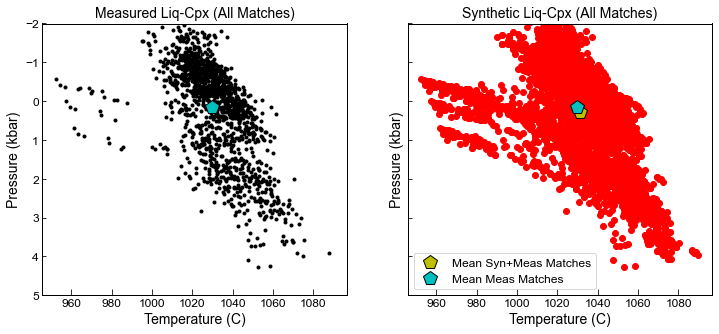

In [20]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
ax1.set_title('Measured Liq-Cpx (All Matches)')
ax1.plot(Meas_All['T_K_calc']-273.15, Meas_All['P_kbar_calc'], '.k')
ax1.plot(np.nanmean(Meas_All['T_K_calc']-273.15), np.nanmean(Meas_All['P_kbar_calc']), 'pk',
        mfc='c', ms=15, label="Mean Meas Matches")

#ax1.set_ylim([-2, 5])
ax1.invert_yaxis()

#ax1.set_xlim([700, 1200])
ax1.set_xlabel('Temperature (C)')
ax1.set_ylabel('Pressure (kbar)')
ax2.set_title('Synthetic Liq-Cpx (All Matches)')
ax2.plot(Syn_All['T_K_calc']-273.15, Syn_All['P_kbar_calc'], 'or')

ax2.plot(np.nanmean(Syn_All['T_K_calc']-273.15), np.nanmean(Syn_All['P_kbar_calc']), 'pk',
        mfc='y', ms=15,label="Mean Syn+Meas Matches")
ax2.plot(np.nanmean(Meas_All['T_K_calc']-273.15), np.nanmean(Meas_All['P_kbar_calc']), 'pk',
        mfc='c', ms=15, label="Mean Meas Matches")

ax2.set_ylim([-2, 5])
ax2.invert_yaxis()
#ax2.set_xlim([700, 1200])

ax2.set_xlabel('Temperature (C)')
ax2.set_ylabel('Pressure (kbar)')
ax2.legend()

## Plotting average for each Cpx (e.g., Cpx1-Liq1, Cpx1-Liq10) with sigma value

C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Pressure (kbar)')

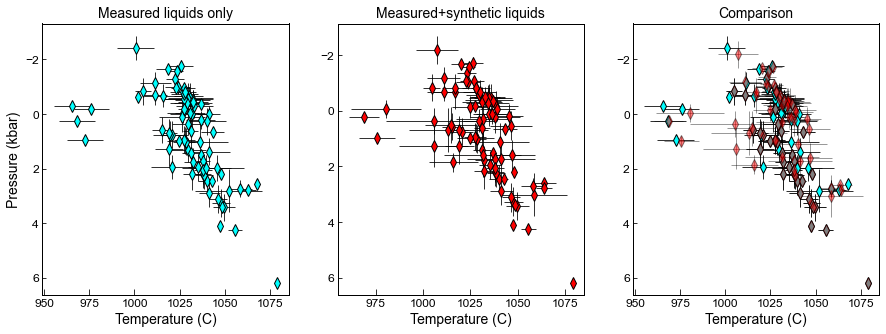

In [21]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 5))#, sharex=True, sharey=True)
ax1.set_title('Measured liquids only')
ax1.errorbar(Meas_Avs['Mean_T_K_calc']-273.15,  Meas_Avs['Mean_P_kbar_calc'],
             xerr=Meas_Avs['st_dev_T_K_calc'], yerr=Meas_Avs['st_dev_P_kbar_calc'],
             fmt='d', ecolor='k', elinewidth=0.8, mfc='cyan', ms=8, mec='k', label='Pennys code')
ax1.invert_yaxis()

ax2.set_title('Measured+synthetic liquids')
ax2.errorbar(Syn_Avs['Mean_T_K_calc']-273.15,  Syn_Avs['Mean_P_kbar_calc'],
             xerr=Syn_Avs['st_dev_T_K_calc'], yerr=Syn_Avs['st_dev_P_kbar_calc'],
             fmt='d', ecolor='k', elinewidth=0.8, mfc='red', ms=8, mec='k', label='Pennys code')
ax2.invert_yaxis()

ax3.set_title('Comparison')
ax3.errorbar(Meas_Avs['Mean_T_K_calc']-273.15,  Meas_Avs['Mean_P_kbar_calc'],
             xerr=Meas_Avs['st_dev_T_K_calc'], yerr=Meas_Avs['st_dev_P_kbar_calc'],
             fmt='d', ecolor='k', elinewidth=0.8, mfc='cyan', ms=8, mec='k', label='Pennys code')
ax3.errorbar(Syn_Avs['Mean_T_K_calc']-273.15,  Syn_Avs['Mean_P_kbar_calc'],
             xerr=Syn_Avs['st_dev_T_K_calc'], yerr=Syn_Avs['st_dev_P_kbar_calc'],
             fmt='d', ecolor='k', elinewidth=0.8, mfc='red', ms=8, mec='k', label='Pennys code', alpha=0.5)
ax3.invert_yaxis()

ax1.set_xlabel('Temperature (C)')
ax2.set_xlabel('Temperature (C)')
ax3.set_xlabel('Temperature (C)')
ax1.set_ylabel('Pressure (kbar)')

# Overall center average
- Here, averaging all measurements

C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Pressure (kbar)')

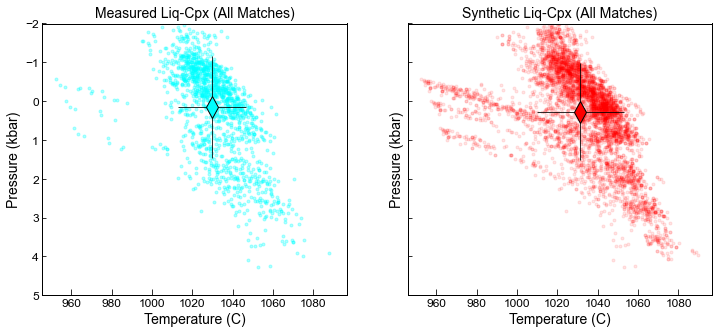

In [22]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

ax1.set_title('Measured Liq-Cpx (All Matches)')
ax1.plot(Meas_All['T_K_calc']-273.15, Meas_All['P_kbar_calc'], '.', color='cyan', alpha=0.3)


ax1.errorbar(np.nanmean(Meas_All['T_K_calc']-273.15),  np.nanmean(Meas_All['P_kbar_calc']),
             xerr=np.nanstd(Meas_All['T_K_calc']-273.15), yerr=np.nanstd(Meas_All['P_kbar_calc']),
             fmt='d', ecolor='k', elinewidth=0.8, mfc='cyan', ms=15, mec='k', label='Pennys code', zorder=100)


#ax1.set_ylim([-2, 5])
ax1.invert_yaxis()

#ax1.set_xlim([700, 1200])
ax1.set_xlabel('Temperature (C)')
ax1.set_ylabel('Pressure (kbar)')
ax2.set_title('Synthetic Liq-Cpx (All Matches)')

ax2.plot(Syn_All['T_K_calc']-273.15, Syn_All['P_kbar_calc'], '.', color='red', alpha=0.1)
ax2.errorbar(np.nanmean(Syn_All['T_K_calc']-273.15),  np.nanmean(Syn_All['P_kbar_calc']),
             xerr=np.nanstd(Syn_All['T_K_calc']-273.15), yerr=np.nanstd(Syn_All['P_kbar_calc']),
             fmt='d', ecolor='k', elinewidth=0.8, mfc='red', ms=15, mec='k', label='Pennys code', zorder=100)


ax2.set_ylim([-2, 5])
ax2.invert_yaxis()
#ax2.set_xlim([700, 1200])

ax2.set_xlabel('Temperature (C)')
ax2.set_ylabel('Pressure (kbar)')

In [23]:
## Comparison to published figure in Scruggs and Putirka

C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


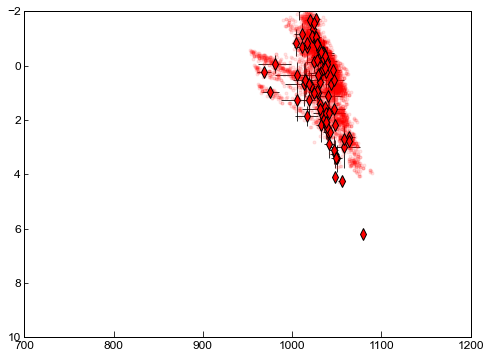

In [24]:
#
fig, ((ax1)) = plt.subplots(1, figsize=(8, 6))

ax1.plot(Syn_All['T_K_calc']-273.15, Syn_All['P_kbar_calc'], '.', color='red', alpha=0.1)

ax1.errorbar(Syn_Avs['Mean_T_K_calc']-273.15,  Syn_Avs['Mean_P_kbar_calc'],
             xerr=Syn_Avs['st_dev_T_K_calc'], yerr=Syn_Avs['st_dev_P_kbar_calc'],
             fmt='d', ecolor='k', elinewidth=0.8, mfc='red', ms=8, mec='k', label='Pennys code')

ax1.set_xlim([700, 1200])
ax1.set_ylim([-2, 10])
ax1.invert_yaxis()

## Diagram from Scruggs and Putirka with the above plot overlain

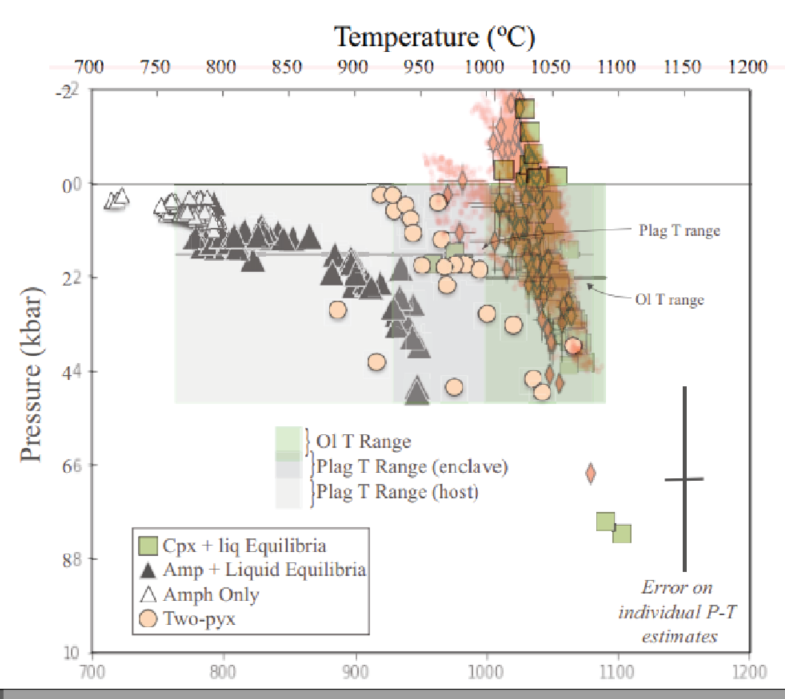